# Minimun Legal Drinking Age

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from dowhy import CausalModel

# Data Cleaning

In [2]:
data = pd.read_stata(
    "../data/mlda.dta"
)

data.head()

,agecell,all,allfitted,internal,internalfitted,external,externalfitted,alcohol,alcoholfitted,homicide,homicidefitted,suicide,suicidefitted,mva,mvafitted,drugs,drugsfitted,externalother,externalotherfitted
0,19.068493,92.825401,91.706146,16.617590,16.738131,76.207817,74.968010,0.639138,0.794344,16.316818,16.284573,11.203714,11.592100,35.829327,34.817780,3.872425,3.448835,8.534373,8.388236
1,19.150684,95.100739,91.883720,18.327684,16.920654,76.773056,74.963066,0.677409,0.837575,16.859964,16.270697,12.193368,11.593611,35.639256,34.633888,3.236511,3.470022,8.655786,8.530174
2,19.232876,92.144295,92.049065,18.911053,17.098843,73.233238,74.950226,0.866443,0.877835,15.219254,16.262882,11.715812,11.595129,34.205650,34.446735,3.202071,3.492069,8.513741,8.662681
3,19.315069,88.427757,92.202141,16.101770,17.272680,72.325981,74.929466,0.867308,0.915115,16.742825,16.261148,11.275010,11.596655,32.278957,34.256302,3.280689,3.514980,8.258285,8.785728
4,19.397261,88.704941,92.342918,17.363520,17.442156,71.341415,74.900757,1.019163,0.949407,14.947726,16.265511,10.984314,11.598189,32.650967,34.062588,3.548198,3.538755,8.417533,8.899288


In [3]:
# all: All deaths

# centralize
data['age'] = data['agecell'] - 21

# treatment variable
data['over21'] = (data['age'] >=0).astype(int)

# other covariates in Regression Discontinuity Desgins
data['age2'] = data['age'].apply(lambda x: x**2)
data['over_age'] = data['age'] * data['over21']
data['over_age2'] = data['age2'] * data['over21']

data = data.dropna()

# Causal Inference


Regression with **Single Covariate**: 

$\bar{M_a} = \alpha + \rho D_a + \gamma a + \epsilon_a$

Regression with **Mulitple Covariate**: 

$\bar{M_a} = \alpha + \rho D_a + \gamma_1 a + \gamma_2 a^2 + \delta_1 aD_a + \delta_2 a^2D_a + \epsilon_a$

In both equations above:
* $a$: age, centralized around 21
* $\bar{M_a}$: is the average all-deaths death rate in age $a$
* $D_a$: if $a$ exceeds 0 (in which the real age exceeds 21)

In the following sections, we'll consider only the causal effect of minimum legal drinking age on **all-deaths death rate** with **multiple covariates**, which should be around 9.55 according to the table 4.1 in Angrist's book (row 1, column 2).

### DoWhy Implementation

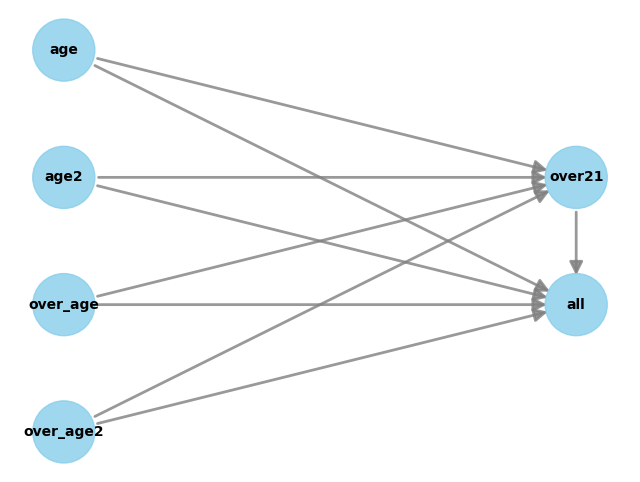

In [4]:
dowhy_rd_model = CausalModel(
    data=data,
    treatment="over21",
    outcome="all",
    common_causes=['age', 'age2', 'over_age', 'over_age2'],
)

dowhy_rd_model.view_model()

In [5]:
identified_estimand = dowhy_rd_model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                        
─────────(E[all|age,age2,over_age2,over_age])
d[over₂₁]                                    
Estimand assumption 1, Unconfoundedness: If U→{over21} and U→all then P(all|over21,age,age2,over_age2,over_age,U) = P(all|over21,age,age2,over_age2,over_age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [6]:
causal_estimate_reg = dowhy_rd_model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True
)

print(causal_estimate_reg)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                        
─────────(E[all|age,age2,over_age2,over_age])
d[over₂₁]                                    
Estimand assumption 1, Unconfoundedness: If U→{over21} and U→all then P(all|over21,age,age2,over_age2,over_age,U) = P(all|over21,age,age2,over_age2,over_age)

## Realized estimand
b: all~over21+age+age2+over_age2+over_age
Target units: ate

## Estimate
Mean value: 9.54778854390338
p-value: [1.97256564e-05]



/home/davidli/anaconda3/envs/mastering-py-metrics/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


### `statsmodels` Implementation

In [7]:


formula = """
all ~ over21 + age + age2 + over_age + over_age2
"""

rd_sm_model = smf.ols(
    formula=formula,
    data=data
)

rd_sm_results = rd_sm_model.fit()

print(rd_sm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    all   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     18.02
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           1.62e-09
Time:                        14:15:04   Log-Likelihood:                -104.57
No. Observations:                  48   AIC:                             221.1
Df Residuals:                      42   BIC:                             232.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     93.0729      1.404     66.301      0.0

# Plot

In [8]:
benchmark_results = smf.ols(
    formula='all ~ over21 + age',
    data=data
).fit()

print(benchmark_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    all   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     32.99
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           1.51e-09
Time:                        14:15:04   Log-Likelihood:                -110.41
No. Observations:                  48   AIC:                             226.8
Df Residuals:                      45   BIC:                             232.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     91.8414      0.805    114.083      0.0

In [9]:
# Calculate the confidence interval of a given fitted OLS model
def ols_predict_ci(
        model: sm.regression.linear_model.RegressionResultsWrapper,
        X: pd.DataFrame,
        alpha: float = .05,
    ) -> pd.DataFrame:
    """Get the prediction with confidence interval.

    Args:
        model (RegressionResultsWrapper): Fitted statsmodels OLS model.
        X (pd.DataFrame): Values to predict.
        alpha (float, optional): Statistical significance. Defaults to .05.

    Returns:
        pd.DataFrame: Predictted results.
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Argument alpha must between 0 and 1")
    
    predictions_df: pd.DataFrame = (
        model
        .get_prediction(X)
        .summary_frame(alpha=alpha)
    )

    return predictions_df[['mean', 'mean_ci_lower', 'mean_ci_upper']]

In [10]:
df = pd.DataFrame({
    "intercept": 1,
    "age": np.linspace(-2.0, 2.0, num=1000),
    "over21": (np.linspace(-2.0, 2.0, num=1000) > 0).astype(int),
})

prediction_data = pd.concat(
    [df, ols_predict_ci(benchmark_results, df, .05)],
    axis=1
)

prediction_data

,intercept,age,over21,mean,mean_ci_lower,mean_ci_upper
0,1,-2.000000,0,93.790738,92.142116,95.439361
1,1,-1.995996,0,93.786836,92.142205,95.431467
2,1,-1.991992,0,93.782933,92.142288,95.423578
3,1,-1.987988,0,93.779030,92.142365,95.415696
4,1,-1.983984,0,93.775128,92.142436,95.407820
...,...,...,...,...,...,...
995,1,1.983984,1,97.570321,95.937629,99.203013
996,1,1.987988,1,97.566418,95.929753,99.203084
997,1,1.991992,1,97.562515,95.921870,99.203161
998,1,1.995996,1,97.558613,95.913982,99.203244


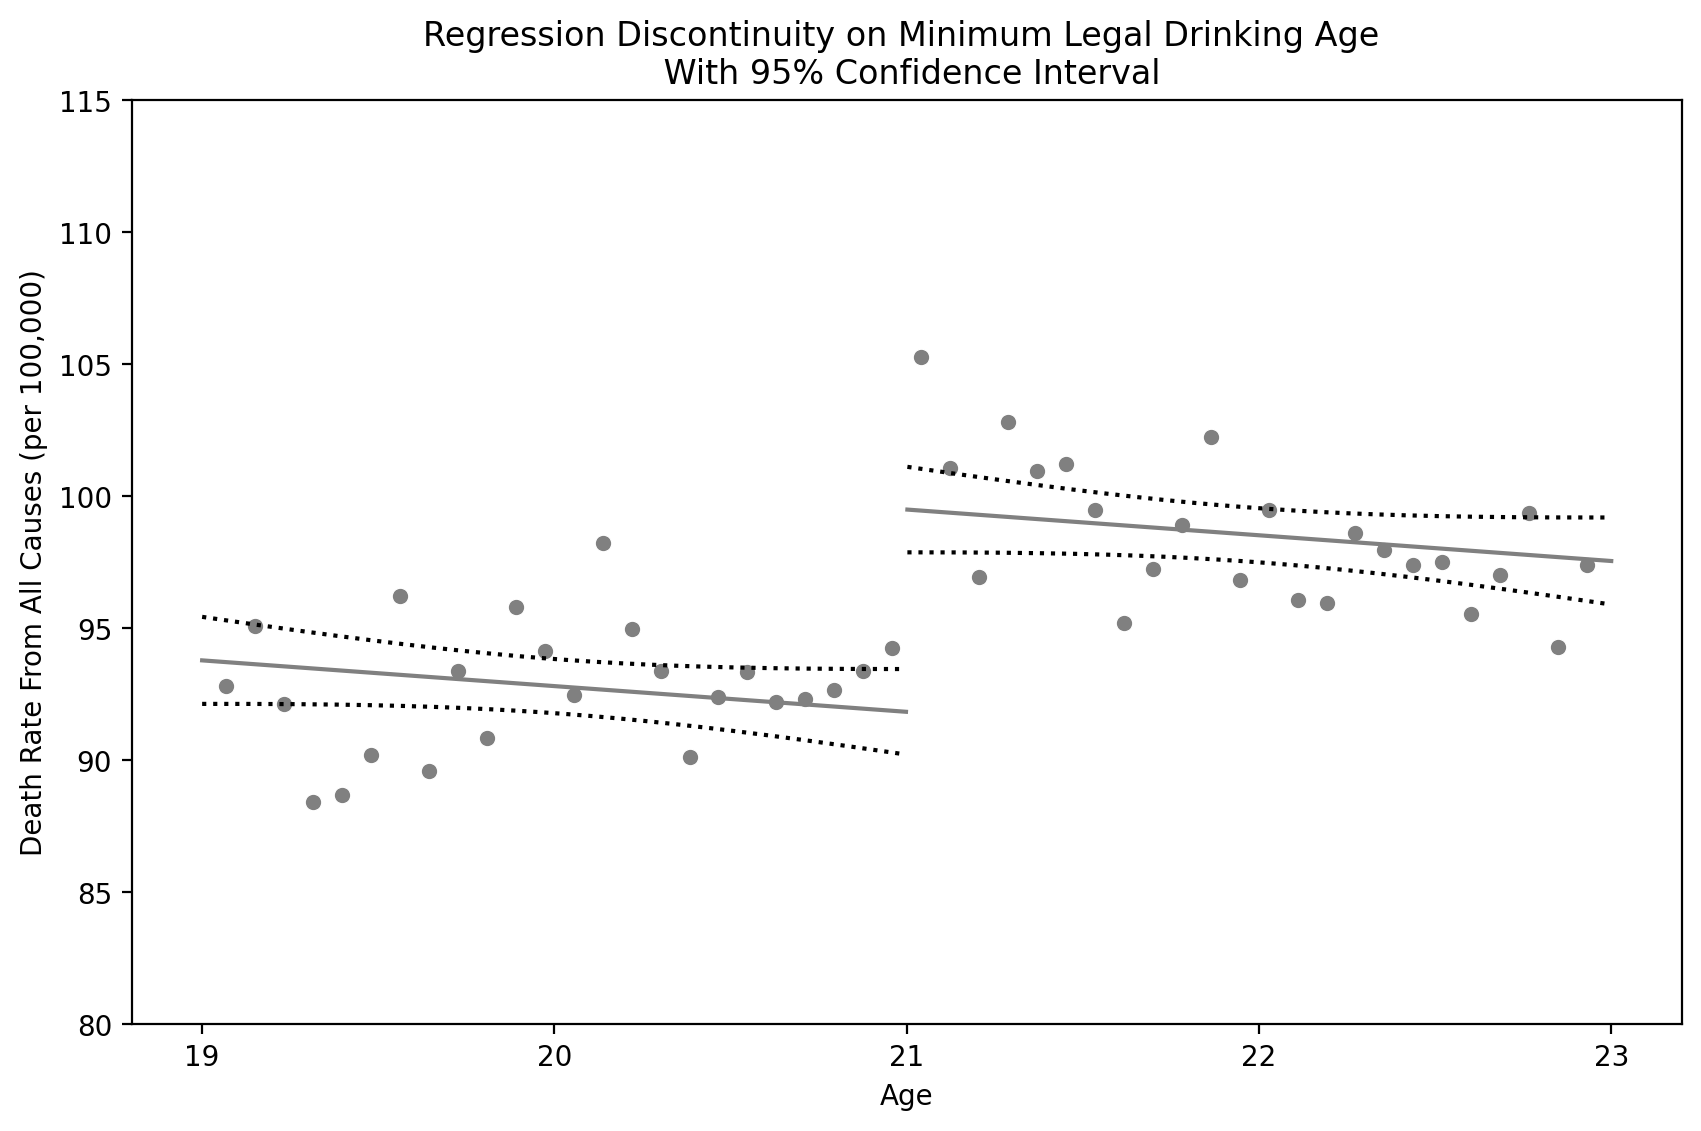

In [11]:
ax: plt.Axes
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

for over21 in [0, 1]:
    sns.scatterplot(
        data=data[data['over21']==over21],
        x="age",
        y="all",
        color='grey',
    )

    sns.lineplot(
        data=prediction_data[prediction_data['over21']==over21],
        x="age",
        y="mean",
        color='grey',
    )

    for boundary in ["lower", "upper"]:
        sns.lineplot(
            data=prediction_data[prediction_data['over21']==over21],
            x="age",
            y=f"mean_ci_{boundary}",
            linestyle=":",
            color='black',
        )

ax.set_xticks(ticks=[-2, -1, 0, 1, 2], labels=[19, 20, 21, 22, 23])
ax.set_ylim([80, 115])

ax.set_xlabel("Age")
ax.set_ylabel("Death Rate From All Causes (per 100,000)")
ax.set_title("Regression Discontinuity on Minimum Legal Drinking Age \n With 95% Confidence Interval")

plt.savefig("../figs/regplot.png")